# Cell Mapping

In this notebook, the actual process of cell mapping will be demonstrated. Please make sure that you have preprocessed the data as per the [Preprocessing notebook](1_preprocessing.ipynb) before running this notebook.

Again, move to the *notebooks* directory of where you extracted the [zip file](https://files.osf.io/v1/resources/7t3rc/providers/osfstorage/5b452fcd4e95590012affb23?action=download&version=1&view_only=338f2b3896fe48ab99f52cc54cd01653&direct).

In [1]:
import nabo

The [Mapping](../../../api.rst#mapping) class is mainly responsible for cell mapping. We start by creating a mapping object, which in this case is also called `mapping`. We pass four parameters to [Mapping](../../../api.rst#mapping) class, in following strict order:

- Name of the output file, in this case `mapping.h5`.
- Name of the reference sample (`WT` here). This can be anything you like and doesn't has to match anything used before in this analysis. Please make sure that this name is only composed of alphabetic characters.
- Name of the input HDF5 file which contains PCA-reduced data for the reference sample (`hvg_pca_WT.h5`).
- Group name in the HDF5 file above which contains the data (`data`).

In [2]:
mapping = nabo.Mapping('../analysis_data/mapping.h5', 'WT',
                       '../analysis_data/hvg_pca_WT.h5', 'data')

Next, we call the [set_parameters](../../../api.rst#nabo.Mapping.set_parameters) method to define four parameters in following order:

- Number of PC components to use (`15`).
- Number of nearest neighbours to be considered (`11`).
- Distance fraction (`0.25`). The ratio of distance to value of target dimension should be smaller than this number. Larger values might lead to a tip effect.
- Number of cells to process in a batch (`500`). Larger values will consume more RAM.

In [3]:
mapping.set_parameters(15, 11, 0.25, 500)

Now we call the [make_ref_graph](../../../api.rst#nabo.Mapping.make_ref_graph) method. This method wraps other functions, which calculate Euclidean distances between reference cells and those which create a shared nearest neighbour graph using these distances. The distances and graph are saved in the output HDF5 file (*mapping.h5* here) under group names which follow patterns `<ref_name>_dist` and `<ref_name>_graph`, respectively. Since we labeled the reference sample as `WT` here, these would be `WT_dist` and `WT_graph`.

In [4]:
mapping.make_ref_graph()

Now that the reference graph is created (we will visualize it later), the next step is to map target cells onto it. For this we call the [map_target](../../../api.rst#nabo.Mapping.map_target) method. It is provided three parameters:

- Label/name for target sample.
- Name of input HDF5 file containing PCA data for target sample. Note that it is crucial that cells were transformed into the same PCA space as the reference, as shown in the Preprocessing notebook.
- HDF5 group name where PCA data is located in the file above.

In [5]:
mapping.map_target('ME', '../analysis_data/hvg_pca_ME.h5', 'data', overwrite=True)

That marks the end of actual mapping. To visualize the results and perform further analysis we use another class called [Graph](../../../api.rst#graph). We start by creating a `Graph` instance (conveniently called `graph` below). Then, we load the reference graph using the [load_from_h5](../../../api.rst#nabo.Graph.load_from_h5) method. This method takes three parameters:

- Name of the input HDF5 file where the graph is stored.
- Name of the sample to be loaded (should be the same as used in the mapping step above)
- Sample type. This can be either 'reference' or 'target'. Please note that the the first sample to be loaded should always be a reference sample.

In [6]:
graph = nabo.Graph()
graph.load_from_h5('../analysis_data/mapping.h5', 'WT', 'reference')

To visualize the graph, we first need to calculate the layout. We do this by calling the [set_ref_layout](../../../api.rst#nabo.Graph.set_ref_layout) method.

In [7]:
graph.set_ref_layout()

100%|██████████| 500/500 [00:05<00:00, 96.02it/s] 

BarnesHut Approximation  took  2.58  seconds
Repulsion forces  took  2.16  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


Nabo provides a highly customizable class called [GraphPlot](../../../api.rst#graphplot) for visualizing the graph. The only mandatory parameter is the `Graph` instance.

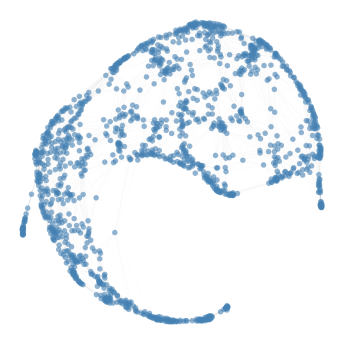

GraphPlot of 1414 nodes

In [8]:
nabo.GraphPlot(graph)

This gives us a sense of graph topology. Next, we partition this graph into clusters using the [make_leiden_clusters](../../../api.rst#nabo.Graph.make_leiden_clusters) method. You can optimize the number of clusters by checking graph modularity using [calc_modularity](../../../api.rst#nabo.Graph.calc_modularity) method. Higher modularity indicates better clustering quality.

In [9]:
graph.make_leiden_clusters(resolution=1.0)

In [10]:
graph.calc_modularity()

0.8476805401424289

We can visualize the cluster on the graph by colouring nodes based on clusters, as shown here:

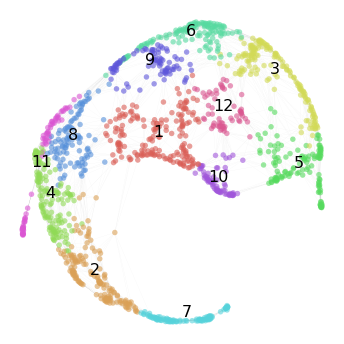

GraphPlot of 1414 nodes

In [11]:
nabo.GraphPlot(graph, vc_attr='cluster', label_attr='cluster')

Now that we have a good sense of our reference graph, let's load the mapped target cells onto this graph using the [load_from_h5](../../../api.rst#nabo.Graph.load_from_h5) method.

In [12]:
graph.load_from_h5('../analysis_data/mapping.h5', 'ME', 'target')

Visualizing the target cells on the reference layout can produce incomprehensible graph layouts. A better approach is to visualize how many target cells are mapped to each reference cell. This can be obtained using the [get_mapping_score](../../../api.rst#nabo.Graph.get_mapping_score) method. One of the optional parameters passed to this method is `weighted`, when set to `True` it will return a weighted score (this is the default setting) and when set to `False` it returns an unweighted score. Unweighted score simply means the number of target cells that mapped to reference cells, while weighted score will take into account the number of shared neighbours between the target and reference cell. [get_mapping_score](../../../api.rst#nabo.Graph.get_mapping_score) takes only one compulsory parameter, i. e. the name of the target sample. This is because the graph may contain multiple target populations.

In [13]:
me_mapping_score = graph.get_mapping_score('ME')

Now we can set the size of each reference node based on their mapping score.

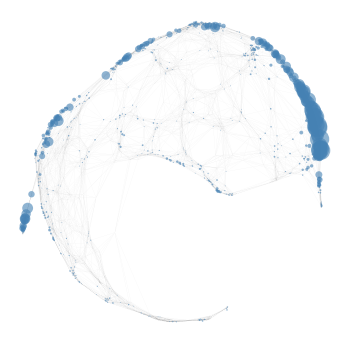

GraphPlot of 1414 nodes

In [14]:
nabo.GraphPlot(graph, vs=me_mapping_score)

We can also visualize mapping score and cluster membership of cells simultaneously.

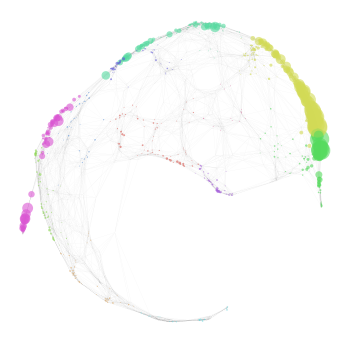

GraphPlot of 1414 nodes

In [15]:
nabo.GraphPlot(graph, vc_attr='cluster', vs=me_mapping_score)

A list of reference cells with high mapping score can easily be obtained by supplying a cutoff value using the `min_score` parameter and setting `sorted_names_only` as True in the [get_mapping_score](../../../api.rst#nabo.Graph.get_mapping_score) method. This list will have names of reference in order of decreasing score, i.e the reference cell with highest mapping score will be the first cell in the list.

In [16]:
high_score_ref_cells = graph.get_mapping_score('ME', min_score=5,
                                               sorted_names_only=True)
len(high_score_ref_cells)

58

One crucial aspect of mapping is to test whether the target cells strongly mapped to a close group of reference cells or if they mapped all over the graph. [calc_contiguous_spl](../../../api.rst#nabo.Graph.calc_contiguous_spl) calculates the mean of the shortest path length (the number of nodes that needs to be traversed before reaching from one node in the graph to another) among subsequent nodes provided in a list. Here we provide [calc_contiguous_spl](../../../api.rst#nabo.Graph.calc_contiguous_spl) with the list of reference cells with high mapping score obtained above.

In [17]:
graph.calc_contiguous_spl(high_score_ref_cells)

3.5789473684210527

To put this into context, we can check the mean shortest path length:

In [18]:
graph.calc_contiguous_spl(
    graph.get_random_nodes(len(high_score_ref_cells))
)

8.31578947368421

When comparing the two numbers above it is clear that cells in `high_score_ref_cells` are much closer (3.6) to each other than randomly expected (8.05). It is to be noted, however, that this function is designed for mappings where target cells are expected to map largely to one cluster. If target cells are heterogeneous and expected to map to different parts/clusters of the reference graph then the result of [calc_contiguous_spl](../../../api.rst#nabo.Graph.calc_contiguous_spl) will not be meaningful.

Let's plot the distribution of mapping score for each cluster:

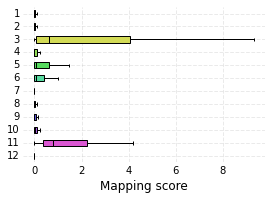

In [19]:
me_cluster_score = graph.get_mapping_score('ME')
nabo.plot_cluster_scores(me_cluster_score, graph.clusters)

The [classify_target](../../../api.rst#nabo.Graph.classify_target) method assigns each target cell in a given sample to a reference cluster. It is important that reference cells have each been assigned a cluster identity before calling this method. By default, this method will return a dictionary with predicted cluster for each target cell, but here we set `ret_counts` to True so that only number of cells classified to each cluster are returned. `null_label` is the label put on cells that remained unassigned.

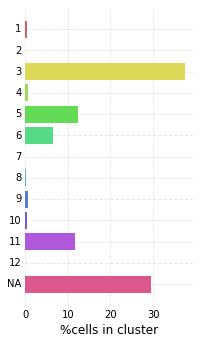

In [20]:
target_cells_cluster = graph.classify_target('ME')
nabo.plot_target_class_counts(target_cells_cluster, graph.clusters, sort=False)

At the end we save the this `Graph` instance to a file. The information about reference graph layout and cluster information as well as data for any loaded target graph will be saved. More about how to load this graph in the next notebook in this tutorial.

In [21]:
graph.save_graph('../analysis_data/hvg_graph.gml')